In [5]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import wmmse, stochastic_wmmse
from src.sc import SyntheticControl
from src.experiment import ExperimentInterferenceModelComparison

%reload_ext autoreload
%autoreload 2
%aimport src

In [6]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-129.505012,-95.751670
1,-126.436490,-115.687022
2,-118.405128,-110.969616
3,-141.272044,-105.483450
4,-123.194534,-99.768342
5,-134.460758,-102.692877
6,-110.767055,-110.417991
7,-122.893603,-105.317230
8,-93.952894,-104.113682
9,-132.696377,-111.156893


In [7]:
simulator = NetworkSimulator(Tx_radius=200, Rx_radius=50, num_Tx_netA=5, num_Rx_per_Tx_netA=5, num_Tx_netB=3, num_Rx_per_Tx_netB=2)

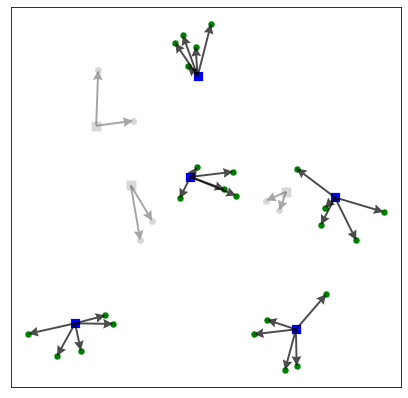

In [8]:
simulator.plot_network()

In [9]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-104.452760,-103.938238,-104.226921,-95.611187,-110.601739,-151.766374,-162.794327,-163.153332,-156.072203,-161.418354,...,-124.131089,-136.902875,-145.092783,-140.352158,-115.474339,-115.796677,-143.621858,-153.738040,-151.893525,-159.466282
1,-156.144635,-149.771789,-155.001155,-162.708270,-156.217806,-101.146922,-109.901521,-100.234289,-93.112306,-107.003827,...,-119.178392,-113.643258,-118.634031,-116.554542,-125.497720,-129.255355,-113.424757,-120.223714,-136.242711,-121.119590
2,-160.731514,-138.424132,-141.948185,-157.551535,-146.930540,-154.165781,-157.089585,-152.223140,-157.226224,-161.264327,...,-148.417189,-123.511098,-117.030115,-136.683632,-129.149406,-142.900719,-143.366976,-149.213633,-117.684711,-114.369838
3,-158.414712,-162.611744,-135.552273,-154.493642,-160.377589,-149.004154,-143.516191,-142.283266,-159.058390,-148.358412,...,-128.779071,-102.691592,-120.343458,-125.603483,-137.379721,-146.644029,-147.358922,-150.901397,-107.211377,-123.155827
4,-149.199269,-131.397661,-127.655890,-147.447415,-140.795749,-112.631477,-117.112664,-130.885040,-121.367456,-127.434847,...,-104.378021,-92.663533,-108.320327,-87.075965,-121.254174,-123.299001,-115.344192,-120.163587,-121.319136,-119.972495
5,-129.079639,-132.457039,-131.309579,-134.410018,-137.418099,-136.854673,-121.100019,-118.230606,-127.093510,-132.090968,...,-119.636036,-110.552760,-108.822618,-101.674606,-104.274992,-107.738186,-111.146415,-113.959273,-141.333665,-122.492506
6,-131.569491,-151.341864,-134.782891,-150.195116,-138.857241,-115.688486,-122.510593,-129.900019,-128.358990,-126.427953,...,-112.994451,-116.383998,-111.826425,-121.469425,-104.284460,-126.261606,-97.865934,-104.480288,-146.209053,-143.608603
7,-160.252497,-144.587727,-156.386483,-154.584450,-152.025893,-128.732493,-135.012572,-136.882536,-126.573922,-137.411621,...,-119.255007,-108.498930,-110.448308,-119.632195,-125.945611,-123.803073,-139.769506,-144.349234,-96.061431,-102.011451


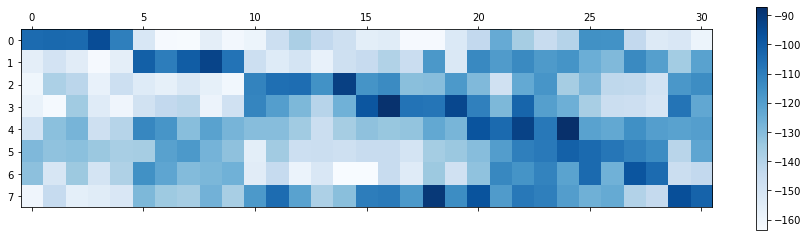

In [10]:
simulator.plot_gain_mat()

## Model Comparisons

In [11]:
simulator.weighted_sum_rate_Gnats([200 for i in range(simulator.num_Rx)], Rx_weights=np.ones(simulator.num_Rx), part='A')

224.57478101116453

In [12]:
model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
model_comparison.data_generation(num_samples=1, max_power=200, netB_power_mode='dependent')
model_comparison.modeling()

In [17]:
model_comparison.run(num_rounds=100, netA_power_mode='random', netB_power_mode='zero')

,interference,sc_bias,lr_bias
0,1.392777e-07,-0.105868,0.143326


In [18]:
model_comparison.run(num_rounds=100, netA_power_mode='random', netB_power_mode='dependent')

,interference,sc_bias,lr_bias
0,1.363132e-07,-0.116172,0.16819


In [19]:
model_comparison.run(num_rounds=100, netA_power_mode='random', netB_power_mode='dependent')

,interference,sc_bias,lr_bias
0,1.375620e-07,-0.104908,0.157585


In [20]:
model_comparison.run(num_rounds=100, netA_power_mode='random', netB_power_mode='uniform')

,interference,sc_bias,lr_bias
0,1.438379e-07,-0.125497,0.107078


In [42]:
pd.DataFrame(model_comparison.observed_signal_and_interferences_list) * 1e9

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,24.654295,104.102444,1185.236871,2299.210867,13.327549,433.592037,11.648744,16.131218,45.340956,19.50136,...,1220.661872,59.830708,297.358853,156.383608,8.566123,4.740121,6739.912903,28.78811,4.26418,12.766435


In [ ]:
num_Rx_netA = len(observed_signal_and_interferences_list[0])
lr_train_X = pd.DataFrame(np.array(powers_list)[:, :num_Rx_netA])
observed_signal_and_interference_data = pd.DataFrame(
    observed_signal_and_interferences_list
)

lr_models = []
for i in range(num_Rx_netA):
    lr_train_y = observed_signal_and_interference_data[i]
    lr_i = LinearRegression().fit(lr_train_X, lr_train_y)
    lr_models.append(lr_i)

## Algorithm Comparisons

In [21]:
max_power = 200
netB_power_training_mode = 'dependent' # ['dependent', 'zero', 'random']
netB_power_testing_mode = 'dependent' # ['dependent', 'zero', 'random', 'uniform']

max_iterations = 500

model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
model_comparison.data_generation(num_samples=1000, max_power=max_power, netB_power_mode=netB_power_training_mode)
model_comparison.modeling(synthetic_constrained=True)
starting_powers_mW = [1e-5 for i in range(simulator.num_Rx)]
# Rx_weights = np.random.uniform(0.1, 1, simulator.num_Rx)
Rx_weights = np.ones(simulator.num_Rx)

In [27]:
rates_original_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='original',
    interference_models=[],
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

In [28]:
rates_local_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='lr_estimate',
    interference_models=model_comparison.lr_models,
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

In [29]:
rates_sc_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='sc_estimate',
    interference_models=model_comparison.sc_models,
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

In [30]:
# rates_lr_method = stochastic_wmmse(
#     simulator=simulator,
#     Rx_powers_mW=starting_powers_mW,
#     Rx_max_powers_mW=max_power,
#     Rx_weights=Rx_weights,
#     interference_mode='lr_estimate',
#     interference_models=model_comparison.lr_models,
#     netB_power_mode = netB_power_testing_mode,
#     power_corr_mat=model_comparison.power_corr_mat,
#     max_iter=max_iterations,
# );

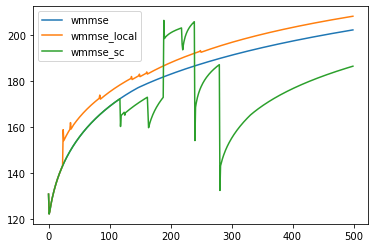

In [31]:
data = pd.DataFrame({
    'wmmse': rates_original_method,
    'wmmse_local': rates_local_method,
    'wmmse_sc': rates_sc_method,
    # 'wmmse_lr': rates_lr_method,
})
data.plot();

In [ ]:
from IPython.display import clear_output

for i in range(10):
    clear_output(wait=True)
    print("Hello World!")